In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:


# Load trips_that_didnt_go_anywhere from CSV
trips_that_didnt_go_anywhere = pd.read_csv('otp_trips_data_for_bikes\\trips_that_didnt_go_anywhere.csv')

# Load trips_that_went_somewhere from pickle
with open('otp_trips_data_for_bikes\\trips_that_went_somewhere.pkl', 'rb') as f:
    trips_that_went_somewhere = pickle.load(f)

# Load other_errors from pickle
with open('otp_trips_data_for_bikes\\other_errors.pkl', 'rb') as f:
    other_errors = pickle.load(f)

In [3]:
# Top 10 rows from trips_that_didnt_go_anywhere DataFrame
print("Top 10 trips_that_didnt_go_anywhere:")
display(trips_that_didnt_go_anywhere.head(10))

# # Top 10 elements from trips_that_went_somewhere (list of tuples)
# print("Top 10 trips_that_went_somewhere:")
# for i, item in enumerate(trips_that_went_somewhere[:10]):
#     print(f"{i+1}: {item}")

# # Top 10 elements from other_errors (list of tuples)
# print("Top 10 other_errors:")
# for i, item in enumerate(other_errors[:10]):
#     print(f"{i+1}: {item}")

Top 10 trips_that_didnt_go_anywhere:


bike_id                 from_station  from_station_lat  from_station_lng  \
0   612804  Branickiego - Ledóchowskiej         52.155439         21.073689   
1   613206             Rondo Wiatraczna         52.244564         21.083806   
2   613345       Szaserów – Garwolińska         52.249684         21.092105   
3   613487            Żelazna - Chłodna         52.237314         20.988849   
4   612403             Plac Na Rozdrożu         52.219962         21.025830   
5   613247   Czerniakowska- Szwoleżerów         52.215851         21.046341   
6   612648    Stryjeńskich - Belgradzka         52.137604         21.050553   
7   612934      Park Kultury w Powsinie         52.116250         21.087655   
8   613429           Książęca - Rozbrat         52.230087         21.030236   
9   612885               Metro Stokłosy         52.156867         21.033840   

                    to_station  to_station_lat  to_station_lng  \
0  Branickiego - Ledóchowskiej       52.155439       21.073689   
1             Rondo Wiatraczna       52.244564       21.083806   
2       Szaserów – Garwolińska       52.249684       21.092105   
3            Żelazna - Chłodna       52.237314       20.988849   
4             Plac Na Rozdrożu       52.219962       21.025830   
5   Czerniakowska- Szwoleżerów       52.215851       21.046341   
6    Stryjeńskich - Belgradzka       52.137604       21.050553   
7      Park Kultury w Powsinie       52.116250       21.087655   
8           Książęca - Rozbrat       52.230087       21.030236   
9               Metro Stokłosy       52.156867       21.033840   

        departure_time         arrival_time  
0  2025-04-02 19:44:13  2025-04-02 19:46:16  
1  2025-04-02 19:44:13  2025-04-02 19:46:16  
2  2025-04-02 19:44:13  2025-04-02 19:46:16  
3  2025-04-02 19:45:14  2025-04-02 19:47:18  
4  2025-04-02 19:44:13  2025-04-02 19:47:18  
5  2025-04-02 19:47:18  2025-04-02 19:49:21  
6  2025-04-02 19:47:18  2025-04-02 19:49:21  
7  2025-04-02 19:48:20  2025-04-02 19:50:23  
8  2025-04-02 19:48:20  2025-04-02 19:50:23  
9  2025-04-02 19:46:16  2025-04-02 19:50:23

In [4]:
warsaw_bike_movements = pd.read_csv('..\\bike_movements_warsaw.csv')

In [5]:
def get_unique_from_stations(df):
    """
    Extract unique destinations from the 'destination' column of the DataFrame.
    """
    return df['from_station'].unique()

In [6]:
print(f"Number of unique station names {len(warsaw_bike_movements['from_station'].unique())}")

unique_from_station_coords = warsaw_bike_movements[['from_station_lat', 'from_station_lng']].drop_duplicates()
num_unique_from_station_coords = len(unique_from_station_coords)
print("Number of unique (from_station_lat, from_station_lng) combinations:", num_unique_from_station_coords)

Number of unique station names 343
Number of unique (from_station_lat, from_station_lng) combinations: 343


In [7]:
# Create a dictionary that maps (from_station_lat, from_station_lng) to from_station name
location_to_station = {}
station_to_location = {}
def create_station_location_mapping(df):
    for _, row in df.iterrows():
        key = (row['from_station_lat'], row['from_station_lng'])
        # Only set if not already present to avoid overwriting with possibly different names for same coords
        if key not in location_to_station:
            location_to_station[key] = row['from_station']

    for key, station in location_to_station.items():
        station_to_location[station] = key
    return location_to_station, station_to_location

In [8]:
location_to_station, station_to_location = create_station_location_mapping(warsaw_bike_movements)

for loc, name in list(location_to_station.items())[:5]:
    print(f"Location: {loc} -> Station Name: {name}")

Location: (52.230978, 21.003676) -> Station Name: Emilii Plater - Złota
Location: (52.155439, 21.073689) -> Station Name: Branickiego - Ledóchowskiej
Location: (52.244564, 21.083806) -> Station Name: Rondo Wiatraczna
Location: (52.249684, 21.092105) -> Station Name: Szaserów – Garwolińska
Location: (52.237314, 20.988849) -> Station Name: Żelazna - Chłodna


In [9]:
from scipy.stats import zscore

# Compute z-scores for station coordinates
coords = unique_from_station_coords[['from_station_lat', 'from_station_lng']].values
z_scores = zscore(coords)

# Calculate the Euclidean norm of the z-scores for each station
z_norm = np.linalg.norm(z_scores, axis=1)

# Define a threshold for outliers (commonly 3 standard deviations)
threshold = 3
outlier_indices = np.where(z_norm > threshold)[0]

# Get outlier stations
outlier_stations = unique_from_station_coords.iloc[outlier_indices]
print("Outlier stations based on location:")
display(outlier_stations)

Outlier stations based on location:


from_station_lat  from_station_lng
191983         41.371631          2.127232
191984         41.423345          2.205672
191986         41.386602          2.116364
191993         41.386799          2.116236
192012         41.413419          2.221750
192018         41.448479          2.199556

In [10]:
# Get the names of stations corresponding to the outlier coordinates
outlier_coords = [tuple(x) for x in outlier_stations[['from_station_lat', 'from_station_lng']].values]
outlier_names = [location_to_station.get(coord, None) for coord in outlier_coords]
print("Outlier station names:")
for name, coord in zip(outlier_names, outlier_coords):
    print(f"{name} at {coord}")

Outlier station names:
AMB - Riera Blanca Nord at (41.371631, 2.127232)
AMB - METRO La Pau at (41.423345, 2.205672)
AMB - Diagonal I at (41.386602, 2.116364)
AMB - Diagonal II at (41.386799, 2.116236)
AMB - Campus Diagonal - Besòs at (41.413419, 2.22175)
AMB - METRO Baró de Viver at (41.448479, 2.199556)


In [11]:
# # Identify outlier and normal station coordinates
# outlier_coords_set = set([tuple(x) for x in outlier_stations[['from_station_lat', 'from_station_lng']].values])
# normal_coords_set = set([tuple(x) for x in unique_from_station_coords[['from_station_lat', 'from_station_lng']].values]) - outlier_coords_set

# # Find trips where either from_station or to_station is an outlier and the other is normal
# def is_outlier(coord):
#     return tuple(coord) in outlier_coords_set

# def is_normal(coord):
#     return tuple(coord) in normal_coords_set

# # Filter trips
# trips_between_outlier_and_normal = warsaw_bike_movements[
#     (
#         warsaw_bike_movements.apply(
#             lambda row: (is_outlier([row['from_station_lat'], row['from_station_lng']]) and is_normal([row['to_station_lat'], row['to_station_lng']])) or
#                         (is_normal([row['from_station_lat'], row['from_station_lng']]) and is_outlier([row['to_station_lat'], row['to_station_lng']])),
#             axis=1
#         )
#     )
# ]

# print(f"Number of trips between outlier and normal stations: {len(trips_between_outlier_and_normal)}")
# display(trips_between_outlier_and_normal.head(10))

In [12]:
no_outlier_stations_coords = [x for x in location_to_station.keys() if x not in outlier_coords]
print(len(no_outlier_stations_coords), "stations without outliers")
print(len((list(location_to_station.keys()))))

337 stations without outliers
343


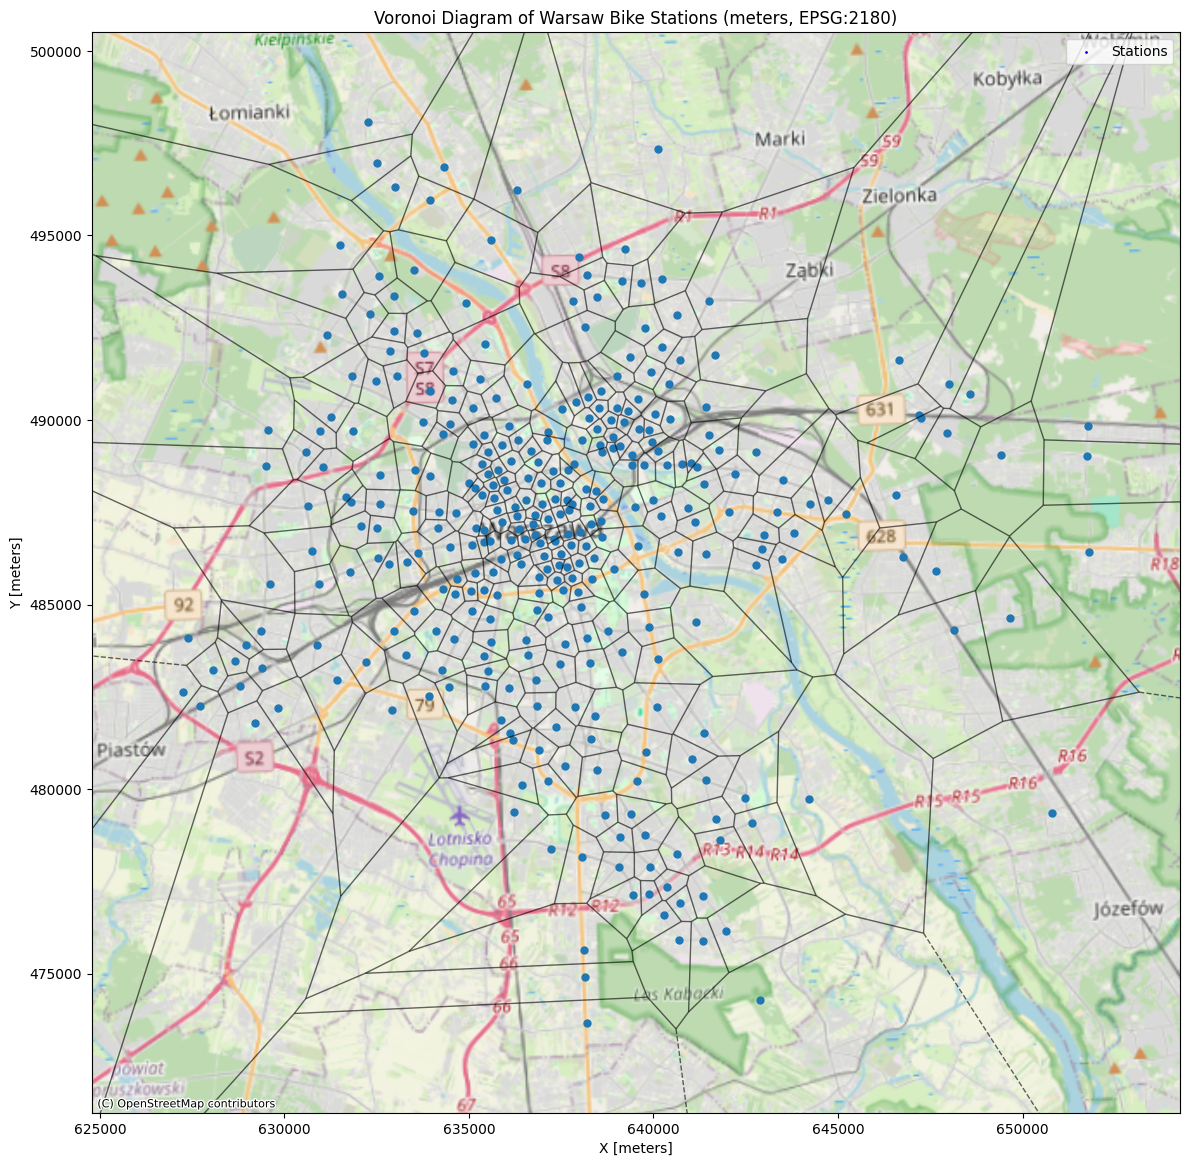

In [13]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from pyproj import Transformer
import contextily as ctx
# Prepare station coordinates for Voronoi (convert lat/lng to meters using EPSG:2180 - Poland CS92)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2180", always_xy=True)
coords_deg = np.array(no_outlier_stations_coords)
lngs = coords_deg[:, 1]
lats = coords_deg[:, 0]
xs, ys = transformer.transform(lngs, lats)
coords_m = np.column_stack([xs, ys])

# Create Voronoi diagram in meters
vor = Voronoi(coords_m)

# Plot Voronoi diagram (no station names, just map)
fig, ax = plt.subplots(figsize=(12, 12))

# Set the CRS for plotting (EPSG:2180)
ax.set_aspect('equal')
ax.set_xlim(xs.min() - 1000, xs.max() + 1000)
ax.set_ylim(ys.min() - 1000, ys.max() + 1000)

# Add basemap (Warsaw area, EPSG:2180)
ctx.add_basemap(ax, crs="EPSG:2180", source=ctx.providers.OpenStreetMap.Mapnik)


voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.6, point_size=10)

# Plot station points
ax.scatter(xs, ys, c='blue', s=1, label='Stations')

ax.set_title("Voronoi Diagram of Warsaw Bike Stations (meters, EPSG:2180)")
ax.set_xlabel("X [meters]")
ax.set_ylabel("Y [meters]")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
station_location_to_departure_count = {x: 0 for x in no_outlier_stations_coords}
for data, iterary in trips_that_went_somewhere:
    from_coords = (data['from_station_lat'], data['from_station_lng'])
    # print(from_coords)
    if from_coords in no_outlier_stations_coords:
        # print('e')
        station_location_to_departure_count[from_coords] +=1
    

In [15]:
print(station_location_to_departure_count)

{(52.230978, 21.003676): 857, (52.155439, 21.073689): 259, (52.244564, 21.083806): 1021, (52.249684, 21.092105): 386, (52.237314, 20.988849): 412, (52.219962, 21.02583): 712, (52.215851, 21.046341): 420, (52.137604, 21.050553): 375, (52.26421, 21.02618): 269, (52.239541, 20.942309): 620, (52.276157, 20.961667): 596, (52.11625, 21.087655): 436, (52.230087, 21.030236): 586, (52.198639, 20.965252): 678, (52.156867, 21.03384): 636, (52.22585, 21.060062): 273, (52.257631, 20.91931): 315, (52.217486, 21.014295): 1280, (52.174435, 21.012881): 468, (52.237208, 21.043758): 913, (52.234745, 21.053651): 590, (52.178689, 21.002814): 1502, (52.194579, 20.982139): 549, (52.162258, 21.028076): 818, (52.273679, 21.043095): 266, (52.260904, 21.072881): 190, (52.247017, 20.989516): 416, (52.213238, 21.021057): 960, (52.239503, 20.913805): 918, (52.238733, 21.050845): 896, (52.208525, 20.946525): 133, (52.275799, 21.056083): 614, (52.270634, 20.950477): 737, (52.23734, 20.965578): 457, (52.246037, 20.962

In [16]:
# Get top 10 stations by departure count using station_location_to_departure_count
top10_departures = sorted(station_location_to_departure_count.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 stations with highest departures count:")
for coord, count in top10_departures:
    name = location_to_station.get(coord, None)
    print(f"{name} at {coord}: {count} departures")


Top 10 stations with highest departures count:
Metro Centrum Nauki Kopernik at (52.239358, 21.031136): 2800 departures
Arkadia at (52.25574, 20.984343): 1788 departures
Metro Dworzec Wileński - Targowa at (52.254419, 21.035632): 1762 departures
Stefana Banacha - UW at (52.210772, 20.984756): 1687 departures
Westfield Mokotów  at (52.178689, 21.002814): 1502 departures
Rondo Jazdy Polskiej at (52.217486, 21.014295): 1280 departures
al. Niepodległości - Batorego at (52.210833, 21.007851): 1265 departures
Lipowa - Dobra at (52.241907, 21.024259): 1252 departures
al. Prymasa Tysiąclecia - Kasprzaka at (52.227451, 20.956839): 1164 departures
Metro Rondo Daszyńskiego at (52.229707, 20.983223): 1153 departures


In [17]:
# from matplotlib.colors import Normalize
# from matplotlib import cm

# # Get departure counts in the same order as unique_from_station_coords
# departure_counts = np.array([station_location_to_departure_count.get(tuple(coord), 0) for coord in unique_from_station_coords.values])

# # Normalize counts to [0, 1]
# norm = Normalize(vmin=departure_counts.min(), vmax=departure_counts.max())
# norm_counts = norm(departure_counts)

# # Use a logarithmic scale for normalization to better distribute colors
# # Add 1 to avoid log(0)
# log_counts = np.log1p(departure_counts)
# norm = Normalize(vmin=log_counts.min(), vmax=log_counts.max())
# # Use a power normalization to compress the high values and spread out the lower ones
# cmap = cm.get_cmap('RdYlGn')
# station_colors = {tuple(coord): cmap(val) for coord, val in zip(unique_from_station_coords.values, norm_counts)}

In [22]:
station_colors = {}

for key in station_location_to_departure_count:
    count = station_location_to_departure_count[key]
    if count < 100:
        station_colors[key] = 'red'
    elif count < 100:
        station_colors[key] = 'orangered'
    elif count < 150:
        station_colors[key] = 'orange'
    elif count < 200:
        station_colors[key] = 'gold'
    elif count < 300:
        station_colors[key] = 'yellow'
    elif count < 400:
        station_colors[key] = 'yellowgreen'
    elif count < 500:
        station_colors[key] = 'limegreen'
    elif count < 600:
        station_colors[key] = 'green'
    elif count < 800:
        station_colors[key] = 'forestgreen'
    else:
        station_colors[key] = 'darkgreen'


Region 313 for point 0: [634, 323, 454, 455, 632]
Region 243 for point 1: [540, 311, 310, 309, 537]
Region 130 for point 2: [366, 244, 243, 242, 241, 365]
Region 76 for point 3: [242, 73, 72, 80, 79, 17, 241]
Region 222 for point 4: [510, 478, 477, 346, 345, 508]
Region 255 for point 5: [551, 470, 335, 334, 328, 327, 465, 550]
Region 111 for point 6: [334, 328, 115, 248, 246, 116, 333]
Region 177 for point 7: [444, 440, 441, 442, 439, 443]
Region 323 for point 8: [645, 631, 630, 629, 644]
Region 115 for point 9: [338, 216, 215, 214, 337]
Region 158 for point 10: [415, 103, 132, 187, 190, 291, 414]
Region 109 for point 12: [321, 208, 118, 117, 119, 168, 320]
Region 92 for point 13: [281, 272, 120, 232, 233, 121, 280]
Region 106 for point 14: [315, 199, 197, 198, 314]
Region 132 for point 15: [372, 249, 248, 246, 247, 368]
Region 10 for point 16: [44, 40, 37, 36, 43]
Region 258 for point 17: [555, 549, 548, 546, 547, 553]
Region 185 for point 18: [449, 420, 419, 295, 319, 448]
Region 307

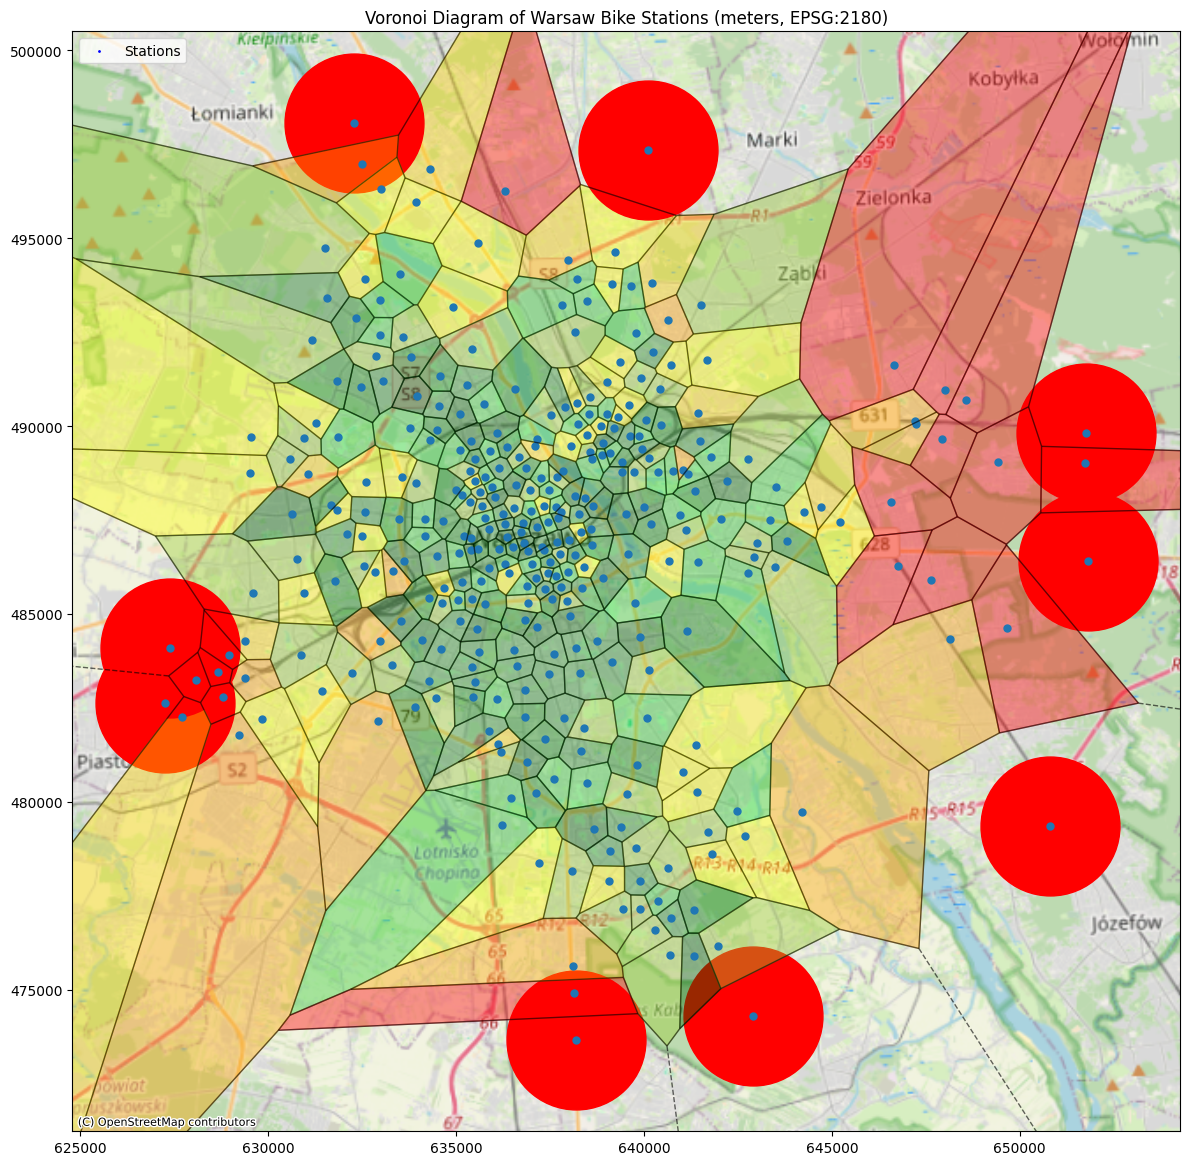

In [80]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from pyproj import Transformer
import contextily as ctx
import random
from matplotlib import cm
# Prepare station coordinates for Voronoi (convert lat/lng to meters using EPSG:2180 - Poland CS92)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2180", always_xy=True)
coords_deg = np.array(no_outlier_stations_coords)
lngs = coords_deg[:, 1]
lats = coords_deg[:, 0]

# Generate random colors for each Voronoi region

xs, ys = transformer.transform(lngs, lats)
coords_m = np.column_stack([xs, ys])
# Create a dictionary mapping from coords_m (tuple) to coords_deg (tuple)
coords_m_to_deg = {tuple(m): tuple(d) for m, d in zip(coords_m, coords_deg)}


# Create Voronoi diagram in meters
vor = Voronoi(coords_m)




# Normalize departure counts to [0, 1] for color mapping

# Get departure counts in the same order as coords_deg
departure_counts = np.array([station_location_to_departure_count.get(tuple(coord), 0) for coord in coords_deg])
norm_counts = (departure_counts - departure_counts.min()) / (departure_counts.ptp() if departure_counts.ptp() > 0 else 1)


region_colors = {}
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    coords = coords_m[point_idx]
    coords_tuple = tuple(coords)
    # if location_to_station[coords_m_to_deg[coords_tuple]] == 'Arkadia':
    #     print(f"Skipping region for point {point_idx} at {coords_tuple} (Metro Centrum Nauki Kopernik)")
    #     region_colors[region_idx] = 'black'
    #     continue
    if not region or -1 in region:
        continue
    print(f"Region {region_idx} for point {point_idx}: {region}")

    # color = cmap(norm_counts[point_idx])
    color = station_colors[coords_m_to_deg[coords_tuple]]
    region_colors[region_idx] = color


new_regions, new_vertices = voronoi_finite_polygons_2d(vor)
print(new_regions)
print(new_vertices  )

for point_idx, region in enumerate(new_regions):
    polygon = [new_vertices[i] for i in region]
    color = region_colors.get(vor.point_region[point_idx], [random.random() for _ in range(3)])
    ax.fill(*zip(*polygon), color=color, alpha=0.4)

# Plot Voronoi diagram (no station names, just map)
fig, ax = plt.subplots(figsize=(12, 12))

# Set the CRS for plotting (EPSG:2180)
ax.set_aspect('equal')
ax.set_xlim(xs.min() - 1000, xs.max() + 1000)
ax.set_ylim(ys.min() - 1000, ys.max() + 1000)

# Add basemap (Warsaw area, EPSG:2180)
ctx.add_basemap(ax, crs="EPSG:2180", source=ctx.providers.OpenStreetMap.Mapnik)

# Fill Voronoi regions with colors
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not region or -1 in region:
        ax.scatter(xs[point_idx], ys[point_idx], c='red', s=10000)  # Plot point if region is invalid
        continue
    polygon = [vor.vertices[i] for i in region]
    color = region_colors.get(region_idx, [random.random() for _ in range(3)])
    ax.fill(*zip(*polygon), color=color, alpha=0.4)

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.6, point_size=10)

# Plot station points
ax.scatter(xs, ys, c='blue', s=1, label='Stations')

ax.set_title("Voronoi Diagram of Warsaw Bike Stations (meters, EPSG:2180)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite
    regions bounded within a certain radius.
    """
    from collections import defaultdict

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    all_ridges = defaultdict(list)
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges[p1].append((p2, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if -1 not in vertices:
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v != -1]
        for p2, v1, v2 in ridges:
            if v2 == -1:
                v1, v2 = v2, v1
            if v1 != -1:
                continue
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            far_point = vor.vertices[v2] + n * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)
        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)


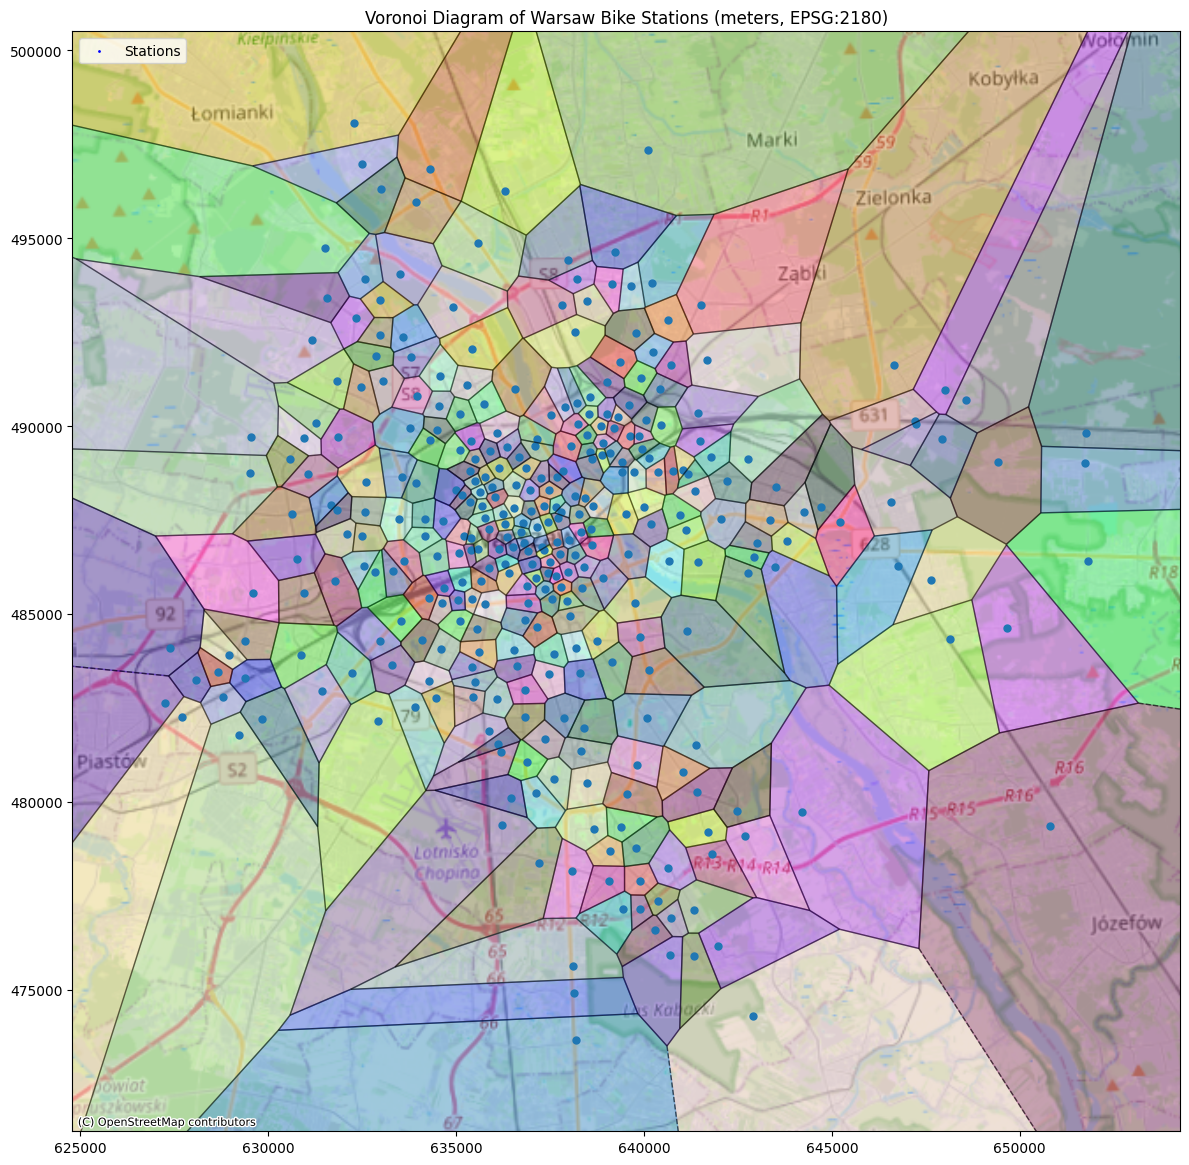

In [79]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from pyproj import Transformer
import contextily as ctx
import random
from matplotlib import cm
# Prepare station coordinates for Voronoi (convert lat/lng to meters using EPSG:2180 - Poland CS92)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2180", always_xy=True)
coords_deg = np.array(no_outlier_stations_coords)
lngs = coords_deg[:, 1]
lats = coords_deg[:, 0]

xs, ys = transformer.transform(lngs, lats)
coords_m = np.column_stack([xs, ys])


# Create Voronoi diagram in meters
vor = Voronoi(coords_m)
new_regions, new_vertices = voronoi_finite_polygons_2d(vor,radius=100000)




# Plot Voronoi diagram (no station names, just map)
fig, ax = plt.subplots(figsize=(12, 12))

# Set the CRS for plotting (EPSG:2180)
ax.set_aspect('equal')
ax.set_xlim(xs.min() - 1000, xs.max() + 1000)
ax.set_ylim(ys.min() - 1000, ys.max() + 1000)

# Add basemap (Warsaw area, EPSG:2180)
ctx.add_basemap(ax, crs="EPSG:2180", source=ctx.providers.OpenStreetMap.Mapnik)

# Fill Voronoi regions with colors
for region, point_idx in zip(new_regions, range(len(xs))):
    polygon = [new_vertices[i] for i in region]
    from shapely.geometry import Polygon
    from shapely.validation import explain_validity

    poly = Polygon(polygon)
    if not poly.is_valid:
        continue
        poly = poly.buffer(0)

    # Ensure it's still valid and not empty
    if poly.is_valid and not poly.is_empty:
        # Convert back to list of (x, y) points
        polygon = list(poly.exterior.coords.__array__())
    else:
        print("Polygon is invalid or empty after fix.")
        fixed_coords = None



    color = [random.random() for _ in range(3)]  # Or use your color logic
    ax.fill(*zip(*polygon), color=color, alpha=0.4)

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.6, point_size=10)

# Plot station points
ax.scatter(xs, ys, c='blue', s=1, label='Stations')

ax.set_title("Voronoi Diagram of Warsaw Bike Stations (meters, EPSG:2180)")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct finite Voronoi polygons from Voronoi diagram in 2D.
    
    Parameters
    ----------
    vor : Voronoi
        Input diagram from scipy.spatial.Voronoi
    radius : float, optional
        Distance to 'points at infinity'.
    
    Returns
    -------
    regions : list of ndarray of int
        Indices of vertices in each revised Voronoi region.
    vertices : ndarray of float
        Coordinates for revised Voronoi vertices.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map of all ridges for a point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct each Voronoi region
    for p1, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region:
            # Finite region
            new_regions.append(region)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 == -1:
                v1, v2 = v2, v1
            if v1 != -1 and v2 != -1:
                continue  # already finite

            # Compute the missing endpoint
            tangent = vor.points[p2] - vor.points[p1]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = vor.vertices[v2] + direction * radius

            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        # Sort region counterclockwise
        vs = np.array([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)
